In [258]:
import matplotlib.pyplot as plt

import numpy as np

import GPy

from athena.active import ActiveSubspaces
from athena.utils import Normalizer

import warnings
warnings.filterwarnings('ignore')

from scipy.interpolate import CubicSpline as spline
from scipy.io import loadmat
from scipy.interpolate import Akima1DInterpolator as akima
from scipy.integrate import quad
from scipy.optimize import root, minimize_scalar
from sklearn.utils import resample
from scipy.stats import uniform

import tikzplotlib as tpl

import pyTOP.fem2d as fe

import nlopt

Setting up the heat diffusion problem with finite elements

In [14]:
# Generate mesh
nx = 16
ny = 16
mesh = fe.Mesh(nx, ny,-1,-1,2,2)
nelem = mesh.getNelems()
nddl = mesh.getNddlsScal()
refElem = fe.RefElement(mesh)

# Boundary conditions
dirichletnodes = np.sort(list(range(0,32))+list(range(1056,1088))+list(range(33,1023,33))+list(range(65,1055,33)))
dirichletddls = np.sort(mesh.getDDLnumerScal()[dirichletnodes].flatten())
ess = np.zeros_like(dirichletddls)

# Initialize diffusion problem
heat_solver = fe.Problem(mesh,1)
heat_solver.setDirichletBC(dirichletddls,ess)
mDivAGradT = fe.DiffusionTerm(refElem, mesh.getNelems())
heat_solver.addTerm(mDivAGradT)
f = lambda x : 56*(1-np.abs(x[0])-np.abs(x[1]))**6
heatsource = fe.SourceTermScal(refElem)
heatsource.setParams(f)
heat_solver.addTermRHS(heatsource)

# Physical Parameters
k1 = 2
k2 = 1
Emax = 1.35

Beginning mesh generation...
Mesh generated!


In [219]:
def displayDesignTri(sol):
    # dens = np.ones(nelem)
    # dens[free] = sol
    vertices = mesh.getElemNodes()[:,:3]
    coords = mesh.getNodeCoord()
    plt.figure(figsize=(8,8))
    for i in range(nelem):
        cv = coords[vertices[i,:]]
        plt.fill(cv[:,0],cv[:,1],facecolor=(((52-83)*sol[i]+83)/255,((201-138)*(sol[i])+138)/255, (((235-150)*sol[i])+150)/255),edgecolor="w",linewidth=1)
    plt.title("Bimaterial distribution (k1 = black, k2 = white)")
    tpl.save("eigenvector.tex")
    plt.show()

In [323]:
def displayDesignTriBW(sol):
    # dens = np.ones(nelem)
    # dens[free] = sol
    vertices = mesh.getElemNodes()[:,:3]
    coords = mesh.getNodeCoord()
    plt.figure(figsize=(8,8))
    for i in range(nelem):
        cv = coords[vertices[i,:]]
        plt.fill(cv[:,0],cv[:,1],facecolor=(1-sol[i],1-sol[i],1-sol[i]),edgecolor="r",linewidth=1)
    plt.title("Bimaterial distribution (k1 = black, k2 = white)")
    tpl.save("solutionAS.tex")
    plt.show()

Setting up function + gradient to be analyzed with the active subspace method

In [296]:
# Problem to compute matrix of gradient of basis functions
probleme_grad = fe.Problem(mesh,1)
gradugradu = fe.DiffusionTerm(refElem, mesh.getNelems())
csttensorfield = [np.eye(2) for k in range(nelem)]
gradugradu.setParams(csttensorfield)
probleme_grad.addTerm(gradugradu)
probleme_grad.solve(OnlyAssembly=True)
GradMatrix = probleme_grad.getCurrentElemMat()

# Declare Objective (volume) + Constraint (energy) and gradients
def V(x,normalizer=None):
    if normalizer is not None:
        x = normalizer.inverse_transform(x)
    return np.dot((0.5*(2/ny)**2)*np.ones(nelem),(x+1)/2)

def dV(x,normalizer=None):
    if normalizer is not None:
        x = normalizer.inverse_transform(x)
    return (0.25*(2/ny)**2)*np.ones(nelem)

def G(x,normalizer=None):
    if normalizer is not None:
        x = normalizer.inverse_transform(x)
    tensorfield = [((k1-k2)*(x[k]+1)/2 + k2)*np.eye(2) for k in range(nelem)]
    mDivAGradT.setParams(tensorfield)
    U=heat_solver.solve()
    j = 0.5*heat_solver.getCurrentMatrix().dot(U).dot(U)
    print(f"Thermal energy = {j}")
    return j - Emax

def dG(x,normalizer=None):
    if normalizer is not None:
        x = normalizer.inverse_transform(x)
    grad = np.zeros(nelem)
    tensorfield = [((k1-k2)*(x[k]+1)/2 + k2)*np.eye(2) for k in range(nelem)]
    mDivAGradT.setParams(tensorfield)
    U=heat_solver.solve()
    for k in range(nelem):
        grad[k] = (-1/4)*(k1-k2)*GradMatrix[:,nddl*k:nddl*(k+1)].dot(U).dot(U)
    return grad



Beginning assembly...
Assembly done!


In [89]:
np.random.seed(42)

# Global parameters
n_samples = nelem
input_dim = nelem

# Uniformly distributed inputs
lb = -1 * np.ones(input_dim)
ub = 1 * np.ones(input_dim)

def inputs_uniform(n_samples, n_pars, lb,  ub):
    return np.vstack(np.array([np.random.uniform(lb[i], ub[i], n_samples) for i in range(n_pars)]).T)

def profile(active, ss, f_out, N=1):
    return np.array([f_out(ss.inverse_transform(active)[0]) for i in range(N)])

# Generate and normalize inputs
X = inputs_uniform(n_samples, input_dim, lb, ub)
nor = Normalizer(lb, ub)

def sampler(x, normalizer=None):
    GG = np.zeros((x.shape[0],1))
    if normalizer is not None:
        x = normalizer.inverse_transform(x)
    for i in range(x.shape[0]):
        GG[i,0] = G(x[i,:].flatten(),normalizer)
    return GG

Compute df (this step is very long because the FEM code is not optimized)

In [56]:
df = np.zeros((n_samples, input_dim))
for i in range(n_samples):
    df[i,:] = dG(X[i,:])
np.save("dfData",df)

Beginning assembly...
Assembly done!
Beginning solving...
Solved!
Beginning assembly...
Assembly done!
Beginning solving...
Solved!
Beginning assembly...
Assembly done!
Beginning solving...
Solved!
Beginning assembly...
Assembly done!
Beginning solving...
Solved!
Beginning assembly...
Assembly done!
Beginning solving...
Solved!
Beginning assembly...
Assembly done!
Beginning solving...
Solved!
Beginning assembly...
Assembly done!
Beginning solving...
Solved!
Beginning assembly...
Assembly done!
Beginning solving...
Solved!
Beginning assembly...
Assembly done!
Beginning solving...
Solved!
Beginning assembly...
Assembly done!
Beginning solving...
Solved!
Beginning assembly...
Assembly done!
Beginning solving...
Solved!
Beginning assembly...
Assembly done!
Beginning solving...
Solved!
Beginning assembly...
Assembly done!
Beginning solving...
Solved!
Beginning assembly...
Assembly done!
Beginning solving...
Solved!
Beginning assembly...
Assembly done!
Beginning solving...
Solved!
Beginning 

Load precomputed df

In [ ]:
df = np.load("dfData.npy")

Compute the active subspace and study eigenvalue decay

In [57]:
# Compute the active subspace
asub = ActiveSubspaces(dim=1)
asub.fit(gradients=df)

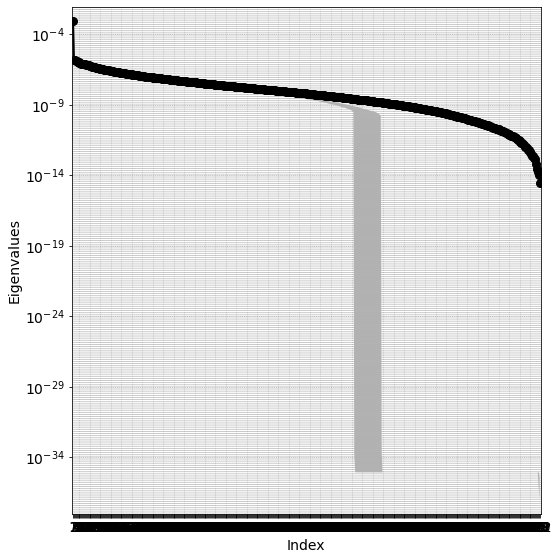

(0,0.000882448329127676)
(1,1.5953761821851023e-06)
(2,1.489499783719553e-06)
(3,1.383757980590466e-06)
(4,1.2411339490419155e-06)
(5,1.1333426582558588e-06)
(6,1.0449642267748638e-06)
(7,1.018367092349931e-06)
(8,8.842110106606098e-07)
(9,8.625994793559538e-07)


In [60]:
asub.plot_eigenvalues()
for i in range(10):
    print(f"({i},{asub.evals[i]})")

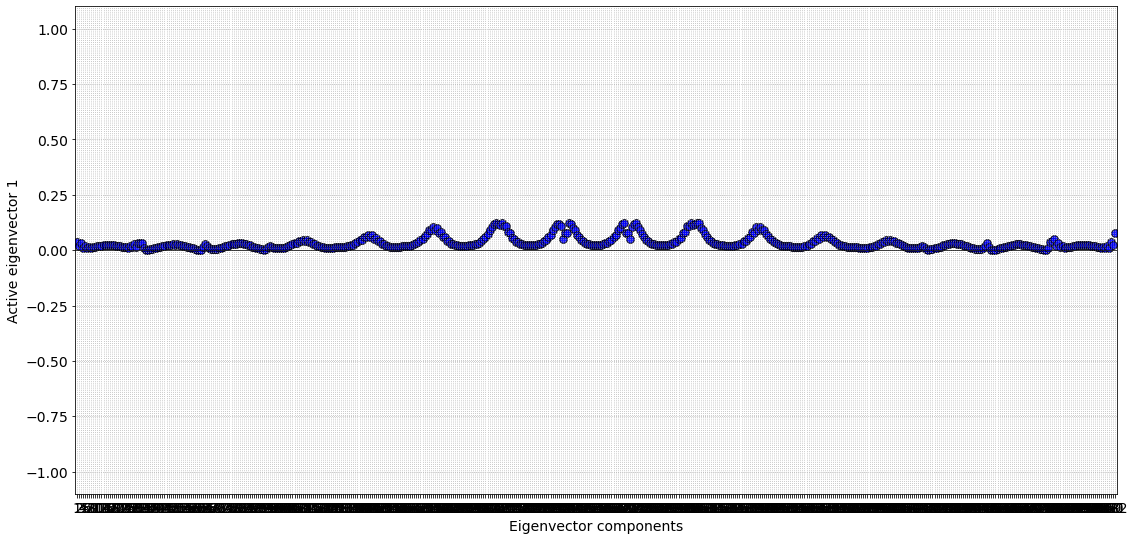

In [187]:
asub.plot_eigenvectors(n_evects=1,figsize=(16,8))

In [225]:
eigenvec = (asub.evects[:,0])
ymax = 1/np.max(np.abs(eigenvec))
ymin = -1/np.max(np.abs(eigenvec))
print(ymax)
print(ymin)

8.091233729349964
-8.091233729349964


0.5617952733445718

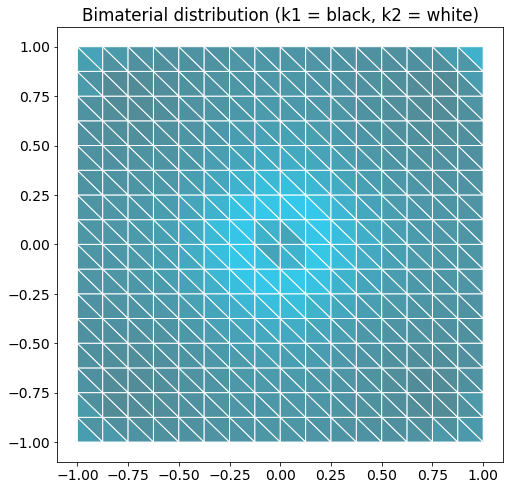

In [226]:
displayDesignTri(ymax*eigenvec)


Determine the profile along the active subspace

In [98]:
M_test = 50
X_test = inputs_uniform(M_test, input_dim, lb, ub)
x_reduced = asub.transform(X_test)[0]
#asub.inverse_transform(x_forward)
Gx = sampler(X_test)
np.save("fData",Gx)
np.save("Xtest",X_test)

Beginning assembly...
Assembly done!
Beginning solving...
Solved!
Beginning assembly...
Assembly done!
Beginning solving...
Solved!
Beginning assembly...
Assembly done!
Beginning solving...
Solved!
Beginning assembly...
Assembly done!
Beginning solving...
Solved!
Beginning assembly...
Assembly done!
Beginning solving...
Solved!
Beginning assembly...
Assembly done!
Beginning solving...
Solved!
Beginning assembly...
Assembly done!
Beginning solving...
Solved!
Beginning assembly...
Assembly done!
Beginning solving...
Solved!
Beginning assembly...
Assembly done!
Beginning solving...
Solved!
Beginning assembly...
Assembly done!
Beginning solving...
Solved!
Beginning assembly...
Assembly done!
Beginning solving...
Solved!
Beginning assembly...
Assembly done!
Beginning solving...
Solved!
Beginning assembly...
Assembly done!
Beginning solving...
Solved!
Beginning assembly...
Assembly done!
Beginning solving...
Solved!
Beginning assembly...
Assembly done!
Beginning solving...
Solved!
Beginning 

In [242]:
X_test = np.load("Xtest.npy")
Gx = np.load("fData.npy")

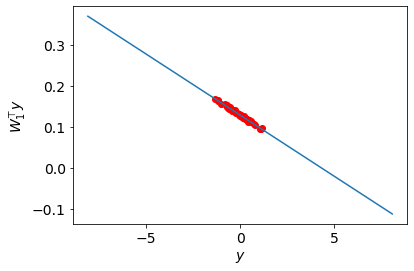

In [246]:
# Linear fit
coeff = np.polyfit(x_reduced.flatten(),Gx,1)
p = lambda x : np.polyval(coeff,x) 

plt.figure(figsize=(6, 4))
plt.scatter(x_reduced.flatten(), Gx, c='r', label='Optimal profile')
yy = np.linspace(ymin,ymax)
plt.plot(yy,p(yy))
plt.xlabel("$y$")
plt.ylabel("$W_1^\\top y$")
tpl.save("energyprofile.tex")
plt.show()

Determine the bias to reach a given conservativeness threshold

In [342]:
# Initial parameters
betal = 0
betau = 10
beta_eps = (betau+betal)/2
tol = 1e-5
err = np.inf
tau = 0.99
n = 0
mode = True # Mode == true uses bootstraping, Mode == false uses Chernoff bounds

while err > tol and n<=50:

    # Biased linear fit
    coeffb = np.polyfit(x_reduced.flatten(),Gx+beta_eps,1)
    pb = lambda x : np.polyval(coeffb,x) 
    print(f"Iteration {n} : fit done")

    # Generate S sample from training data
    fhat = pb(x_reduced.flatten())
    Sk = fhat - Gx
    avgSk = np.mean(Sk)

    nboot = 20000
    avg = np.zeros(nboot)
    var = np.zeros(nboot)
    if mode: # bootstraping only
        for i in range(nboot):
            avg[i] = np.mean(resample(np.array(Sk.flatten()),n_samples=M_test)>0)
        prob = np.mean(avg)
    else: # chernoff inequality
        # Compute bootstrap estimator for expected value
        for i in range(nboot):
            avg[i] = np.mean(resample(np.array(Sk.flatten()),n_samples=M_test))
            var[i] = np.var(resample(np.array(Sk.flatten()),n_samples=M_test), ddof=1)
        avgSkboot = np.mean(avg)
        varSkboot = np.mean(var)
        # print(avgSkboot)
        # print(varSkboot)
        print(f"Iteration {n} : bootstrap estimator done (Eboot[S] = {avgSkboot}, Vboot[S] = {varSkboot})")

        if(avgSkboot < 0):
            betal = beta_eps
            beta_eps = (betau+betal)/2
            print(f"Iteration {n} : expected value = {avgSkboot} < 0. Increasing bias.")
        else:
            # Approximate Chernoff bound
            def Chernoff():
                f = lambda x : np.mean(np.exp(x * (np.abs(Sk - avgSkboot) - avgSkboot)))
                #print((np.abs(Sk - avgSkboot) - avgSkboot))
                # ax = np.linspace(0,100,100)
                # plt.plot(ax,list(map(f,ax)))
                # plt.show()
                result = minimize_scalar(f,bounds=(0,100),method="bounded")
                #print(result)
                return result["fun"]
            
            Ci = np.zeros(1)
            for i in range(1):
                Ci[i] = Chernoff()
            prob = np.mean(1-Ci)
            print(f"Iteration {n} : concentration bound done")

    err = np.abs(prob-tau)

    beta_previous = beta_eps
    if prob > tau:
        betau = beta_eps
    else:
        betal = beta_eps
    beta_eps = (betau+betal)/2

    print(f"Iteration {n} : bias = {beta_previous}, success probability = {prob}")
        
    n = n + 1


Iteration 0 : fit done
Iteration 0 : bias = 5.0, success probability = 1.0
Iteration 1 : fit done
Iteration 1 : bias = 2.5, success probability = 1.0
Iteration 2 : fit done
Iteration 2 : bias = 1.25, success probability = 1.0
Iteration 3 : fit done
Iteration 3 : bias = 0.625, success probability = 1.0
Iteration 4 : fit done
Iteration 4 : bias = 0.3125, success probability = 1.0
Iteration 5 : fit done
Iteration 5 : bias = 0.15625, success probability = 1.0
Iteration 6 : fit done
Iteration 6 : bias = 0.078125, success probability = 1.0
Iteration 7 : fit done
Iteration 7 : bias = 0.0390625, success probability = 0.9421450000000001
Iteration 8 : fit done
Iteration 8 : bias = 0.05859375, success probability = 0.9925820000000002
Iteration 9 : fit done
Iteration 9 : bias = 0.048828125, success probability = 0.9759190000000001
Iteration 10 : fit done
Iteration 10 : bias = 0.0537109375, success probability = 0.9869560000000002
Iteration 11 : fit done
Iteration 11 : bias = 0.05615234375, success

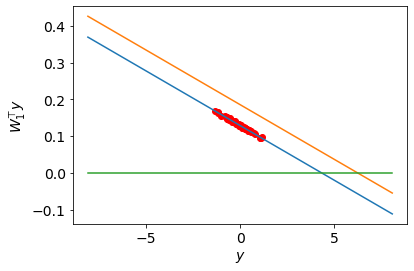

In [343]:
plt.figure(figsize=(6, 4))
plt.scatter(x_reduced.flatten(), Gx, c='r', label='Optimal profile')
yy = np.linspace(ymin,ymax)
plt.plot(yy,p(yy))
plt.plot(yy,pb(yy))
plt.plot(yy,np.zeros_like(yy))
plt.xlabel("$y$")
plt.ylabel("$W_1^\\top y$")
plt.show()

Optimization problem with the low-dimensional constraint

In [344]:
def Obj(x,grad):
    grad[:] = dV(x)
    print(f"Volume = {V(x)}")
    return V(x)

# biased surrogate
def Consb(x,grad):
    y = asub.transform(x)[0]
    grad[:] = coeffb[0][0].flatten()*eigenvec.flatten()
    print(f"Constraint = {pb(y)[0]}")
    return pb(y)[0]

# unbiased surrogate
def Cons(x,grad):
    y = asub.transform(x)[0]
    grad[:] = coeff[0][0].flatten()*eigenvec.flatten()
    print(f"Constraint = {p(y)[0]}")
    return p(y)[0]


optim_solver = nlopt.opt(nlopt.LD_MMA, nelem)
optim_solver.set_min_objective(Obj)
optim_solver.set_lower_bounds(-1.0*np.ones(nelem))
optim_solver.set_upper_bounds(1.0*np.ones(nelem))
optim_solver.add_inequality_constraint(Consb)
optim_solver.set_param("verbosity",2)
#solver.set_stopval(1e25)
optim_solver.set_maxeval(500)
optim_solver.set_xtol_abs(1e-10)

sol = optim_solver.optimize(1.0*np.ones(nelem))
result = optim_solver.last_optimize_result(); # 1 = success, 2 = values over the max value, 4 = xtol conv
print(f"Exit code = {result}")
print(f"Neval J = {optim_solver.get_numevals()}")

Volume = 4.0
Constraint = -0.32508200080562655
Volume = 3.992247945553594
Constraint = -0.32310232307119313
Volume = 3.9196888000899985
Constraint = -0.30457256096789864
Volume = 3.3806736309953775
Constraint = -0.17276531741122966
Volume = 2.6494463906624928
Constraint = -0.06665202078549379
Volume = 2.0576762686132613
Constraint = -0.03294846656067882
Volume = 1.726190707872161
Constraint = -0.012147223750976072
Volume = 1.592241829110876
Constraint = -0.004679884308715188
Volume = 1.5339783197405201
Constraint = -0.0022132887778819332
Volume = 1.5049186976245035
Constraint = -0.0011781448661700722
Volume = 1.4872264441372944
Constraint = -0.0007799591096520897
Volume = 1.4785768471579774
Constraint = -0.00032901155523179515
Volume = 1.4737980501412233
Constraint = -0.0002184740267729135
Volume = 1.4709653221122951
Constraint = -0.00011491799303384176
Volume = 1.469175621311101
Constraint = -8.166370640960707e-05
Volume = 1.467901460972469
Constraint = -6.394790380495619e-05
Volume =

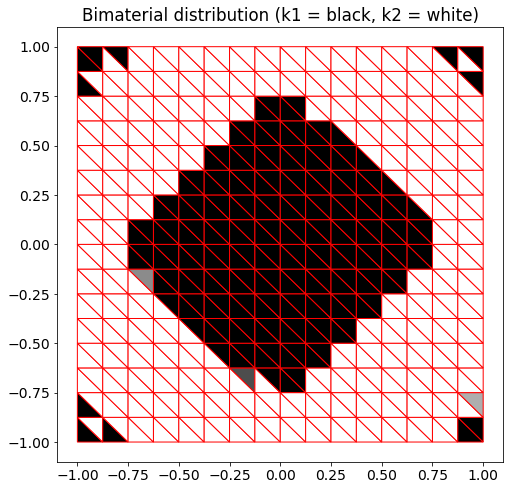

In [345]:
displayDesignTriBW((sol+1)/2)

Compute exact constraint violation

In [346]:
100*G(sol)/Emax

Beginning assembly...
Assembly done!
Beginning solving...
Solved!
Thermal energy = 1.4205587092270369


5.226571053854576